In [ ]:
pip install aiohttp

In [1]:
import aiohttp
import asyncio
import async_timeout
from bs4 import BeautifulSoup
import re
import numpy as np
import csv

**Scrapping**

In [ ]:
DATA = 'data.csv'

async def fetch(session, url):
    async with async_timeout.timeout(10):
        async with session.get(url) as response:
            return await response.text()
        
async def soup_d(html, display_result=False):
    soup = BeautifulSoup(html, 'html.parser')
    if display_result:
        print(soup.prettify())
    return soup
           
async def main():
    async with aiohttp.ClientSession() as session:
        url1 = 'http://zpp.rospotrebnadzor.ru/Forum/Appeals/Details/'
        url2 = '14921'
        data = []
        
        while len(data) < 1000:
            url = url1 + url2
            html = await fetch(session, url)
            soup = await soup_d(html)
            content_area = soup.find("p", {"class": 'appeal-details-message'})
            if content_area is None:
                url2 = str(int(url2)-1)
            else:
                text = re.sub(r'[\r]+', '', content_area.text)
                text = re.sub(r'[\n]+', ' ', text)
                data.append(text)
                url2 = str(int(url2)-1)
        
        data = np.array_split(data, 1000)
        with open(DATA, "w") as file:
            writer = csv.writer(file)
            writer.writerows(data)
            
        print('Over')
        
        
loop = asyncio.get_event_loop()
try:
    loop.run_until_complete(main())
except:
    pass

**Нормализация**

In [ ]:
pip install pymorphy2

In [2]:
import pymorphy2
import collections 
import multiprocessing

In [3]:
# Распaкуем данные

d = []
with open('data.csv') as File:  
    reader = csv.reader(File)
    for row in reader:
        d.append(row)
data = []
for l in d:
    data.extend(l) 

In [4]:
# Удалим пунктуацию
data = map(lambda x: re.sub('[,\.!?_]', '', x), data)
data = list(data)

# Удалим цифры
data = map(lambda x: re.sub(r'\d', '', x), data)
data = list(data)

In [5]:
#Функция нормализации

morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    words = text.split() 
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

In [6]:
#Распараллелим

pool = multiprocessing.Pool()
norm_data = pool.map(lemmatize, data)

Посмотрим на облако слов

In [ ]:
pip install wordcloud

In [7]:
from wordcloud import WordCloud

In [8]:
wcloud = []
for l in norm_data:
    wcloud.extend(l) 
long_string = ','.join(wcloud)

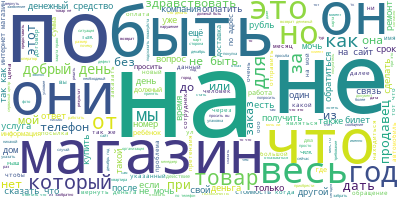

In [9]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
#Возможно стоит убрать из рассмотрения некоторые слова, поскольку они не несут смысловой нагрузки

In [10]:
extra = ['добрый', 'день', 'здравствовать', 'что', 'это', 'по', 'этот', 'или', 'на', 'не', 'но', 'весь', 'из', 'за', 
         'то', 'как', 'можно', 'пожалуйста', 'какой', 'который', 'ли', 'для', 'быть', 'так', 'же', 'при', 'нет',
         'после', 'от', 'тот', 'он', 'они', 'такой', 'до', 'без', 'мы', 'мой']

for i in range(1000):
    norm_data[i] = list(set(norm_data[i]) - set(extra))  

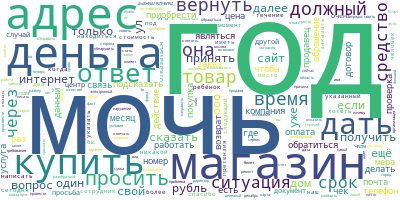

In [11]:
wcloud = []
for l in norm_data:
    wcloud.extend(l) 
long_string = ','.join(wcloud)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

**Векторизация**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
# Соединим нормализованные слова обратно в тексты
for i in range(1000):
    norm_data[i] = ' '.join(norm_data[i])

In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(norm_data)
count_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

**Кластеризация (LDA)**

In [15]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA

In [16]:
def print_topics(model, count_vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_topics = 10
number_words = 7

lda = LDA(n_components=number_topics)
lda = lda.fit(X)

print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
магазин год товар мочь вернуть просить дать

Topic #1:
открытый оправдать правильный риск узнать скидка функционировать

Topic #2:
ghuy орган прибыть рыбалка например воздух пр

Topic #3:
дон автобус разъяснение связать увидеть аэропорт emexru

Topic #4:
вода например каков чат заблуждение слишком прилагаю

Topic #5:
длительный поставщик занятие плюс класс аэропорт заказчик

Topic #6:
бесплатно обмен сложиться воспользоваться мтс марка здание

Topic #7:
фитнес приложить абонемент клуб класс орган заявление

Topic #8:
файл вызвать якобы прикрепить независимый праздник граница

Topic #9:
закрытый собственник ук состав предприятие лежалый увидеть


In [22]:
#Разделим жалобы по кластерам

q = LDA(n_components=number_topics).fit_transform(X)

appeals = []
for i in range(1000):
    appeals.append(q[i].argsort()[-1])

In [23]:
colors = {0: 'skyblue', 1: 'green', 2: 'yellow', 3: 'crimson', 
          4: 'maroon', 5:'salmon', 6:'orange', 7:'blue', 
          8:'red', 9:'black'}

color = []
for i in range(1000):
    color.append(colors[appeals[i]])

**T-SNE**

In [24]:
from sklearn.manifold import TSNE

In [25]:
X_embedded = TSNE(n_components=2)
Y = X_embedded.fit_transform(q)

**Scatter plot**

In [26]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

output_notebook()
plot = figure(title="T-SNE Clustering of {} LDA Topics".format(number_topics), 
              plot_width=900, plot_height=700)
plot.scatter(Y[:,0], Y[:,1], color = color)
show(plot)

Loading BokehJS ...